In [1]:
import pandas as pd

In [120]:
train_df = pd.read_csv('../DisCopy/DiscoGeM/DiscoGeM_corpus/DiscoGeMcorpus_annotations_wide_datasplit.csv')
train_df = train_df[['arg1', 'arg2', 'domconn_step1', 'majoritylabel_sampled', 'split']]
train_df.head()

,arg1,arg2,domconn_step1,majoritylabel_sampled,split
0,It had been agreed that they should all meet i...,"At one end of the big barn, on a sort of raise...",to set the scene,precedence,train
1,"Old Major (so he was always called, though the...",He was twelve years old and had lately grown r...,to provide background information,arg2-as-detail,train
2,Before long the other animals began to arrive ...,The hens perched themselves on the window-sill...,in addition,conjunction,train
3,The hens perched themselves on the window-sill...,Clover was a stout motherly mare approaching m...,for information,arg2-as-detail,train
4,Clover was a stout motherly mare approaching m...,A white stripe down his nose gave him a somewh...,furthermore,conjunction,train


<AxesSubplot:ylabel='Frequency'>

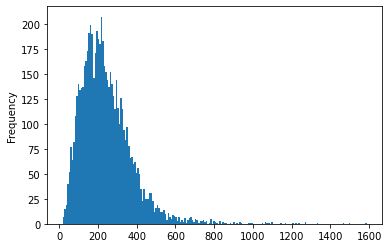

In [117]:
def get_len(sent):
    return(len(sent))

train_df.apply(lambda x: get_len(x['arg2']), axis=1).plot.hist(bins=200)

In [121]:
train_df['arg1'] = train_df.apply(lambda x: x['arg1'][:400], axis=1)
train_df['arg2'] = train_df.apply(lambda x: x['arg2'][:400], axis=1)
train_df.head()

,arg1,arg2,domconn_step1,majoritylabel_sampled,split
0,It had been agreed that they should all meet i...,"At one end of the big barn, on a sort of raise...",to set the scene,precedence,train
1,"Old Major (so he was always called, though the...",He was twelve years old and had lately grown r...,to provide background information,arg2-as-detail,train
2,Before long the other animals began to arrive ...,The hens perched themselves on the window-sill...,in addition,conjunction,train
3,The hens perched themselves on the window-sill...,Clover was a stout motherly mare approaching m...,for information,arg2-as-detail,train
4,Clover was a stout motherly mare approaching m...,A white stripe down his nose gave him a somewh...,furthermore,conjunction,train


In [115]:

print(len(test_df))

1288


In [93]:
# plot values of implicit connectives

# TODO: Move to Discopy image

from collections import Counter, OrderedDict
relation_distribution = {}
relation_distribution_sorted = {}
for index, row in train_df.iterrows():
    conn = row['domconn_step1']
    rel = row['majoritylabel_sampled']
    if rel not in relation_distribution:
        relation_distribution[rel] = Counter()
    relation_distribution[rel].update({conn: 1})

for rel in relation_distribution:
    relation_distribution_sorted[rel] = OrderedDict(relation_distribution[rel].most_common())

#sample value
print(relation_distribution_sorted['reason'])

for rel in relation_distribution_sorted:
    w = relation_distribution_sorted[rel]
    plt.bar(w.keys(), w.values())
    plt.xticks(rotation = 90)
    plt.title('Implicit connectives:'+rel)
    plt.savefig('../DisCopy/graphs/connectives/implicit/'+rel+'.jpg')
    plt.tight_layout()
    plt.clf()

OrderedDict([('because', 194),
             ('specifically', 27),
             ('also', 25),
             ('this is because', 19),
             ('however', 14),
             ('for the reason that', 12),
             ('in addition', 7),
             ('this was because', 7),
             ('in more detail', 6),
             ('and', 5),
             ('for example', 4),
             ('the reason is that', 4),
             ('furthermore', 3),
             ('incidentally', 3),
             ('consequently', 3),
             ('but', 3),
             ('considering this', 3),
             ('accordingly', 3),
             ('the reason being', 3),
             ('nothing', 2),
             ('as a result', 2),
             ('despite this', 2),
             ('previously', 2),
             ('indeed', 1),
             ('ultimately', 1),
             ('unfortunately', 1),
             ('given', 1),
             ('whilst', 1),
             ('instead', 1),
             ('in particular', 1),
             ('

In [122]:
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pickle
import os
from transformers import BertTokenizer
import pandas as pd

class MNLIDataBert(Dataset):

  def __init__(self, train_df, val_df, test_df):
    self.label_dict = {'synchronous':0, 'precedence':1, 'succession':2, 'reason':3, 'result':4, 
                      'arg1-as-cond':5, 'arg2-as-cond':6, 'arg1-as-negcond':7, 'arg2-as-negcond':8,
                      'arg1-as-goal':9, 'arg2-as-goal':10, 'arg1-as-denier':11, 'arg2-as-denier':12, 'contrast':13, 
                      'similarity':14, 'conjunction':15, 'disjunction':16, 'arg1-as-instance':17, 'arg2-as-instance':18, 
                      'arg1-as-detail':19, 'arg2-as-detail':20, 'equivalence':21, 'arg1-as-manner':22, 
                      'arg2-as-manner':23, 'arg1-as-excpt':24, 'arg2-as-excpt':25, 'arg2-as-subst':26, 'differentcon':27, 'norel':28}

    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    self.base_path = '/content/'
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) # Using a pre-trained BERT tokenizer to encode sentences
    self.train_data = None
    self.val_data = None
    self.test_data = None
    self.init_data()

  def init_data(self):
    self.train_data = self.load_data(self.train_df)
    self.val_data = self.load_data(self.val_df)
    self.test_data = self.load_data(self.test_df)

  def load_data(self, df):
    MAX_LEN = 512
    token_ids = []
    mask_ids = []
    seg_ids = []
    y = []

    premise_list = df['arg1'].to_list()
    hypothesis_list = df['arg2'].to_list()
    label_list = df['majoritylabel_sampled'].to_list()

    for (premise, hypothesis, label) in zip(premise_list, hypothesis_list, label_list):
      premise_id = self.tokenizer.encode(premise, add_special_tokens = False)
      hypothesis_id = self.tokenizer.encode(hypothesis, add_special_tokens = False)
      pair_token_ids = [self.tokenizer.cls_token_id] + premise_id + [self.tokenizer.sep_token_id] + hypothesis_id + [self.tokenizer.sep_token_id]
      premise_len = len(premise_id)
      hypothesis_len = len(hypothesis_id)

      segment_ids = torch.tensor([0] * (premise_len + 2) + [1] * (hypothesis_len + 1))  # sentence 0 and sentence 1
      attention_mask_ids = torch.tensor([1] * (premise_len + hypothesis_len + 3))  # mask padded values

      token_ids.append(torch.tensor(pair_token_ids))
      seg_ids.append(segment_ids)
      mask_ids.append(attention_mask_ids)
      y.append(self.label_dict[label])
    
    token_ids = pad_sequence(token_ids, batch_first=True)
    mask_ids = pad_sequence(mask_ids, batch_first=True)
    seg_ids = pad_sequence(seg_ids, batch_first=True)
    y = torch.tensor(y)
    dataset = TensorDataset(token_ids, mask_ids, seg_ids, y)
    print(len(dataset))
    return dataset

  def get_data_loaders(self, batch_size=32, shuffle=True):
    train_loader = DataLoader(
      self.train_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    val_loader = DataLoader(
      self.val_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    test_loader = DataLoader(
      self.test_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    return train_loader, val_loader, test_loader

def get_splits(train_df, split_function='csv_split'):
  if split_function=='random':
    #split into test and dev
    val_df=train_df.sample(frac=0.1,random_state=200)
    train_df=train_df.drop(val_df.index)

    test_df=train_df.sample(frac=0.1,random_state=200)
    train_df=train_df.drop(test_df.index)
  elif split_function=='csv_split':
    test_df = train_df[train_df['split']=='test']
    val_df = train_df[train_df['split']=='dev']
    train_df = train_df[train_df['split']=='train']

  train_df.dropna(inplace=True)
  val_df.dropna(inplace=True)
  test_df.dropna(inplace=True)
  return train_df, val_df, test_df

train_df = train_df[['arg1', 'arg2', 'domconn_step1', 'majoritylabel_sampled', 'split']] #already loaded train_df in top cells
train_df, val_df, test_df = get_splits(train_df)
mnli_dataset = MNLIDataBert(train_df, val_df, test_df)
train_loader, val_loader, test_loader = mnli_dataset.get_data_loaders()

/tmp/ipykernel_26631/1560066367.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.dropna(inplace=True)
/tmp/ipykernel_26631/1560066367.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.dropna(inplace=True)
/tmp/ipykernel_26631/1560066367.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.dropna(inplace=True)


KeyboardInterrupt: 

In [ ]:
label_dict = mnli_dataset.label_dict
rev_label_dict = {label_dict[k]:k for k in label_dict.keys()}
rev_label_dict, label_dict

({0: 'synchronous',
  1: 'precedence',
  2: 'succession',
  3: 'reason',
  4: 'result',
  5: 'arg1-as-cond',
  6: 'arg2-as-cond',
  7: 'arg1-as-negcond',
  8: 'arg2-as-negcond',
  9: 'arg1-as-goal',
  10: 'arg2-as-goal',
  11: 'arg1-as-denier',
  12: 'arg2-as-denier',
  13: 'contrast',
  14: 'similarity',
  15: 'conjunction',
  16: 'disjunction',
  17: 'arg1-as-instance',
  18: 'arg2-as-instance',
  19: 'arg1-as-detail',
  20: 'arg2-as-detail',
  21: 'equivalence',
  22: 'arg1-as-manner',
  23: 'arg2-as-manner',
  24: 'arg1-as-excpt',
  25: 'arg2-as-excpt',
  26: 'arg2-as-subst',
  27: 'differentcon',
  28: 'norel'},
 {'synchronous': 0,
  'precedence': 1,
  'succession': 2,
  'reason': 3,
  'result': 4,
  'arg1-as-cond': 5,
  'arg2-as-cond': 6,
  'arg1-as-negcond': 7,
  'arg2-as-negcond': 8,
  'arg1-as-goal': 9,
  'arg2-as-goal': 10,
  'arg1-as-denier': 11,
  'arg2-as-denier': 12,
  'contrast': 13,
  'similarity': 14,
  'conjunction': 15,
  'disjunction': 16,
  'arg1-as-instance': 17,


In [ ]:
from transformers import BertForSequenceClassification, AdamW

device = torch.device('cuda')

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=29).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
def multi_acc(y_pred, y_test):
  acc = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
  return acc

import time

EPOCHS = 5



def train(model, train_loader, val_loader, optimizer):  
  total_step = len(train_loader)

  for epoch in range(EPOCHS):
    start = time.time()
    model.train()
    total_train_loss = 0
    total_train_acc  = 0
    for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(train_loader):
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      seg_ids = seg_ids.to(device)
      labels = y.to(device)

      loss, prediction = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()

      acc = multi_acc(prediction, labels)

      loss.backward()
      optimizer.step()
      
      total_train_loss += loss.item()
      total_train_acc  += acc.item()

    train_acc  = total_train_acc/len(train_loader)
    train_loss = total_train_loss/len(train_loader)
    model.eval()
    total_val_acc  = 0
    total_val_loss = 0
    with torch.no_grad():
      for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(val_loader):
        optimizer.zero_grad()
        pair_token_ids = pair_token_ids.to(device)
        mask_ids = mask_ids.to(device)
        seg_ids = seg_ids.to(device)
        labels = y.to(device)
        
        loss, prediction = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()
        
        acc = multi_acc(prediction, labels)

        total_val_loss += loss.item()
        total_val_acc  += acc.item()

    val_acc  = total_val_acc/len(val_loader)
    val_loss = total_val_loss/len(val_loader)
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)

    print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

In [123]:
train(model, train_loader, val_loader, optimizer)

Epoch 1: train_loss: 0.1983 train_acc: 0.9465 | val_loss: 2.7948 val_acc: 0.4366
00:01:04.71
Epoch 2: train_loss: 0.1338 train_acc: 0.9674 | val_loss: 2.8571 val_acc: 0.4381
00:01:05.22
Epoch 3: train_loss: 0.0945 train_acc: 0.9773 | val_loss: 2.9481 val_acc: 0.4464
00:01:05.35
Epoch 4: train_loss: 0.0678 train_acc: 0.9855 | val_loss: 3.1161 val_acc: 0.4366
00:01:05.46
Epoch 5: train_loss: 0.0599 train_acc: 0.9868 | val_loss: 3.0695 val_acc: 0.4485
00:01:05.13


In [102]:
torch.save(model.state_dict(), 'bert-discogem-nli.pt')

In [104]:
from sklearn.metrics import classification_report

def evaluate(model, iterator):
  start = time.time()
  model.eval()
  total_val_acc  = 0
  total_val_loss = 0

  #for classification report
  y_true = []
  y_pred = []

  with torch.no_grad():
    for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(iterator):
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      seg_ids = seg_ids.to(device)
      labels = y.to(device)
      
      loss, prediction = model(pair_token_ids, 
                            token_type_ids=seg_ids, 
                            attention_mask=mask_ids, 
                            labels=labels).values()
      
      acc = multi_acc(prediction, labels)

      total_val_loss += loss.item()
      total_val_acc  += acc.item()

      argmax_predictions = torch.argmax(prediction,dim=1).tolist()
      labels_list = labels.tolist()
      assert(len(labels_list)==len(argmax_predictions))
      for p in argmax_predictions: y_pred.append(rev_label_dict[int(p)])
      for l in labels_list: y_true.append(rev_label_dict[l])

  val_acc  = total_val_acc/len(val_loader)
  val_loss = total_val_loss/len(val_loader)
  end = time.time()
  hours, rem = divmod(end-start, 3600)
  minutes, seconds = divmod(rem, 60)

  print(f'Test_loss: {val_loss:.4f} test_acc: {val_acc:.4f}')
  print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

  print(classification_report(y_true, y_pred))
  return val_loss, val_acc, y_true, y_pred

model.load_state_dict(torch.load('bert-discogem-nli.pt'))
test_loss, test_acc, y_true, y_pred = evaluate(model, test_loader)
print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

Test_loss: 2.1201 test_acc: 0.4182
00:00:02.07
                  precision    recall  f1-score   support

  arg1-as-denier       0.25      0.11      0.15         9
  arg1-as-detail       0.00      0.00      0.00         2
    arg2-as-cond       0.00      0.00      0.00         0
  arg2-as-denier       0.18      0.40      0.25        35
  arg2-as-detail       0.57      0.46      0.51        94
arg2-as-instance       0.24      0.22      0.23        23
   arg2-as-subst       0.00      0.00      0.00         3
     conjunction       0.51      0.57      0.54       164
        contrast       0.27      0.21      0.24        19
      precedence       0.54      0.41      0.46        37
          reason       0.30      0.25      0.27        40
          result       0.59      0.55      0.57       160
      similarity       0.00      0.00      0.00         2
      succession       0.00      0.00      0.00         2
     synchronous       0.00      0.00      0.00         4

        accuracy       

/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

In [ ]:
# TODO: Make a README for this folder and delete unwanted files. Link snli and discogem notebooks.
